This notebook shows how to extract the estimated normalized entropy rate (nER) using our network from the previous examples formulated the PNAS article by [Tejedor et al.](https://www.pnas.org/content/114/44/11651) . The wikipage for the nER (without the discussion of the normalization factor) is [here](https://en.wikipedia.org/wiki/Entropy_rate).

One of the points of this notebook is to illustrate how powerful NetworkX is for understanding the connectivity metrics. Note there are numerous network related [algorithms](https://networkx.github.io/documentation/stable/reference/algorithms/index.html) that may be insightful to understanding ecological and environmental processes in deltas.

In [1]:
import rasterio
from rasterio.transform import array_bounds
from rasterio import plot

import geopandas as gpd
from shapely.geometry import Point

import numpy as np
import matplotlib.pyplot as plt
import scipy

from pathlib import Path
from tqdm import tqdm
import networkx as nx

from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from matplotlib import colors, colorbar, cm
from matplotlib.colors import LinearSegmentedColormap

from orinoco import (export_edges_to_geodataframe, 
                     export_nodes_to_geodataframe, 
                     dfs_line_search,
                     direct_line,
                     direct_channel_network,
                     get_cropped_profile)

# Directories of Orinoco Products

We have only done this for the stamen mask. **We assume you have run Notebooks 1 and 2 using the stamen mask.**

In [2]:
map_name = 'stamen_terrain_12'
data_path = Path(f'data/{map_name}')

In [3]:
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir.exists()

True

# Initialize Paths for Entropy Plots

In [4]:
plot_entropy = Path('plots/entropy')
plot_entropy.mkdir(exist_ok=True, parents=True)

# Opening the Products

In [5]:
chanG = nx.read_gpickle(products_for_map_dir/'channel_network.pkl')
edges_df = gpd.read_file(products_for_map_dir/'orinoco_edges.geojson')
nodes_df = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson')

# Obtain Directed Acyclic Sub-Network with Single Source

We select a node with the label we want (easier to remember a label from QGIS). We select a node just south of the Intracoastal Waterway.

In [6]:
label_value = 218
nodes_with_label = [node for node, data in chanG.nodes(data=True) if data['label'] == label_value]
# Just a sanity check
nodes_with_label[0], len(nodes_with_label)

((655309.6677721699, 3280061.9439748363), 1)

We can obtain the relevant subgraph as indicated [here](https://stackoverflow.com/a/13934101/2348348) according to our directivity.

In [7]:
source_node = nodes_with_label[0]
downstream_nodes = list(nx.shortest_path(chanG, source_node).keys())
chanG_sub = chanG.subgraph([source_node] + downstream_nodes).copy()

# Because some nodes are no longer junctions, this ensures the segments correspond to the current graph.
chanG_sub = direct_channel_network(chanG_sub.to_undirected())

Let's plot everything to make sure everything is as we expect.

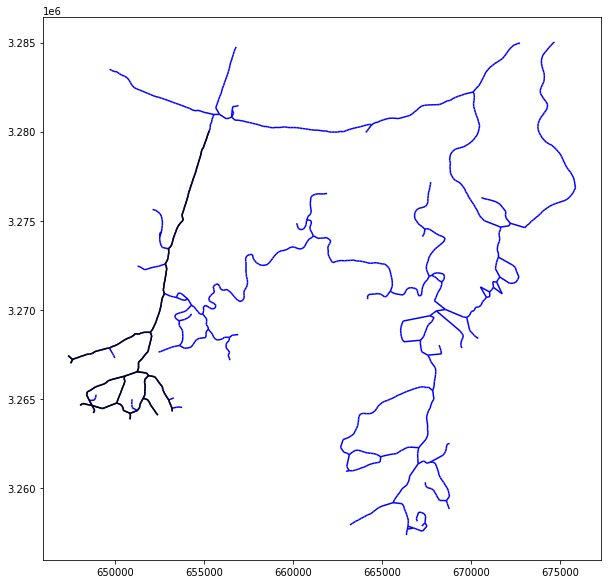

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

edges_df.plot(ax=ax, edgecolor='blue')

edges_df_sub = export_edges_to_geodataframe(chanG_sub, edges_df.crs)
nodes_df_sub = export_nodes_to_geodataframe(chanG_sub, edges_df.crs)

edges_df_sub.plot(ax=ax, edgecolor='black')

# Merging Edges

We want our network to have nodes that either a junction, source, or sink. Additional nodes will affect the stationary distribution we define later. As such, we merge edges that have degree 2 and are not in the previous category. We define new edges whose width is an average of all the merged edges and whose length is the sum of the merged edges.

We create dictionaries via networkx whose key is the node and whose value is the said attribute.

In [9]:
width_dict = nx.get_edge_attributes(chanG, 'width_m')
weight_dict = nx.get_edge_attributes(chanG, 'weight')
node_data = dict(chanG.nodes(data=True))

The depth-first search lines searches by edges and yields a list of edges in a partition.

In [10]:
lines = list(dfs_line_search(chanG_sub, source_node))


# We also make sure that our lines are correctly oriented
direct_line_partial = lambda line: direct_line(line, node_data)
lines = list(map(direct_line_partial, lines))

We create a dictionary so we can create a new networkx graph.

In [11]:
edge_data_merged = {(line[0][0], line[-1][1], k):  {'segment_id': k,
                                                    # Average width along edge segment
                                                    'width': np.mean([width_dict[edge] for edge in line]),
                                                    # Total Length of Line
                                                    'weight': np.sum([weight_dict[edge] for edge in line])}
                     for (k, line) in enumerate(lines)

                    }

# We will track this because we are going to add more edges connecting the source and sinks.
current_edge_index = len(lines)
current_edge_index

18

We now create a directed Multigraph using our merged edges.

In [12]:
chanG_merged = nx.MultiDiGraph()
chanG_merged.add_edges_from(edge_data_merged.keys())
nx.set_edge_attributes(chanG_merged, edge_data_merged)

We visualize

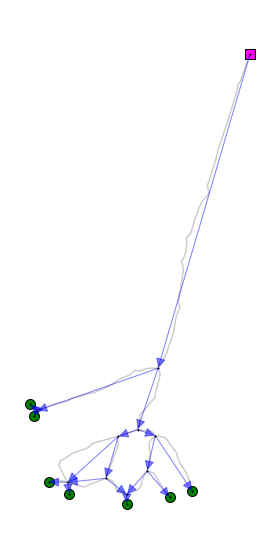

In [13]:
fig, ax = plt.subplots(figsize=(6, 10))

# Uncomment to visualize the entire channel network in comparison
# edges_df.plot(ax=ax, edgecolor='black', alpha=.2)

pos = {node: node for node in chanG.nodes()}

nx.draw(chanG_merged, 
        pos=pos, 
        node_size=1,
        edge_width=.25,
        edge_color=[(0, 0, 1, .5)]*len(chanG_merged.edges()),
        arrows=True,
        arrowsize=20,
        ax=ax,
        node_color='black')

edges_df_sub.plot(ax=ax, edgecolor='black', alpha=.2)

nodes_df_sub[nodes_df_sub.interface_adj].plot(color='green', ax=ax, markersize=100, edgecolor='black')

nodes_df_source = export_nodes_to_geodataframe(chanG.subgraph([source_node]), nodes_df.crs)
nodes_df_source.plot(color='blue', ax=ax, markersize=100, facecolor='magenta', edgecolor='black', marker='s')

# Connect Source and Outlets

In the Tejedor construction, we connect source and sinks so the flow of water through the network is conserved. This also allows us to compute the stationary distribution.

In [14]:
outlets = [node for node, data in chanG_sub.nodes(data=True) if data['interface_adj']]
len(outlets)

7

We create a new graph that connects the source and sink.

In [15]:
stationary_distribution_graph = chanG_merged.copy()
edges_outlet_to_source = [(outlet, source_node, k + current_edge_index) 
                            for k, outlet in enumerate(outlets)]
stationary_distribution_graph.add_edges_from(edges_outlet_to_source)
nx.set_edge_attributes(stationary_distribution_graph,
                      {edge: {'width': 1.} for edge in edges_outlet_to_source})
current_edge_index = len(lines) + len(outlets)

Let's plot the new graph for a sanity check.

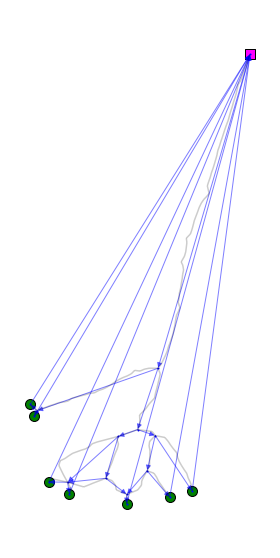

In [16]:
fig, ax = plt.subplots(figsize=(5, 10))

# Draw the multigraph
nx.draw(stationary_distribution_graph, 
        pos=pos, 
        node_size=1,
        edge_width=.25,
        edge_color=[(0, 0, 1, .5)]*len(stationary_distribution_graph.edges()),
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
edges_df_sub.plot(ax=ax, edgecolor='black', alpha=.2)


# Plot the outlets as green circles
nodes_df_sub[nodes_df_sub.interface_adj].plot(color='green', ax=ax, markersize=100, edgecolor='black')

# Plot the source Node as a square
nodes_df_source = export_nodes_to_geodataframe(chanG.subgraph([source_node]), nodes_df.crs)
nodes_df_source.plot(color='blue', ax=ax, markersize=100, facecolor='magenta', edgecolor='black', marker='s')

# Compute the Stationary Distribution and normalize Entropy Rate (nER)

We now compute the stationary distribution and the normalized entropy rate using `numpy` and `scipy`. The stationary distribution is computed as the left eigenvector of the transition matrix determined according to the related random walk determined by the network above.

Here is a good [reference](https://arxiv.org/abs/1612.03281) for random walks on graphs in addition to Tejedors series on these constructions in his series of papers on river/channel networks [[1](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014WR016577%4010.1002/%28ISSN%291944-7973.CONART1)][[2](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014WR016604%4010.1002/%28ISSN%291944-7973.CONART1)].

We review some important parts of the theory above. We define a random walk on the network in which the probability a random walker at node at $i$ goes to $j$ is proportional to the width at of the edges connected down stream. The stationary distribtution $\pi$ is then the probablity distribution of the random walker at each node.

In [17]:
nodes_from_multigraph = list(stationary_distribution_graph.nodes())
stationary_distribution_graph_directed = stationary_distribution_graph.to_directed()

# The weights are determined by width
adj_mat = nx.adj_matrix(stationary_distribution_graph_directed, 
                        nodelist=nodes_from_multigraph,
                        weight='width')

# The trasition matrix is defined to be the probability a node at i --> node j and scaled by width/weight
transition_matrix = np.array((adj_mat / adj_mat.sum(axis=1)))

In [18]:
# We remove warning about casing complex to real values
import warnings

def compute_normalized_entropy_rate(transition_matrix):
    eig_values, eig_vec_l, _ = scipy.linalg.eig(transition_matrix, left=True)
    pi = eig_vec_l[:, 0].real
    pi = (pi / np.sum(pi))
    
    #enusre largest eignvalue is 1
    assert(np.abs(eig_values[0] - 1) < 1e-10)
    # ensure eigenvector is real
    assert(np.linalg.norm(eig_vec_l[:, 0].astype(float) - eig_vec_l[:, 0]) < 1e-10)
    
    log_T = np.log(transition_matrix, where=(transition_matrix>0), out=np.zeros(transition_matrix.shape))
    deg = np.sum((transition_matrix > 0), axis=1)
    normalized_er = np.einsum('ij,ij->i', transition_matrix, log_T) 
    normalized_er /=  np.log(1./deg, where=(deg > 1), out=np.ones(deg.shape))
    normalized_er = np.dot(normalized_er, pi)
    return normalized_er

In [19]:
compute_normalized_entropy_rate(transition_matrix)

/Users/cmarshak/anaconda3/envs/orinoco_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


0.5552677896106569

# Plot for Report

Again, this is a bit messy (we are emulating the messiest plot from Notebook 3). We are opening the Lat/Lon rasters for visualization.

In [20]:
products_for_map_dir_4326 = Path(f'{products_for_map_dir}_4326')

with rasterio.open(products_for_map_dir_4326/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    
with rasterio.open(products_for_map_dir_4326/'water_mask.tif') as ds:
    water_mask = ds.read(1)

with rasterio.open(products_for_map_dir_4326/f'{map_name}.tif') as ds:
    stamen_arr = ds.read()
    transform = ds.transform
    profile_4326 = ds.profile

Let's do a sanity check.

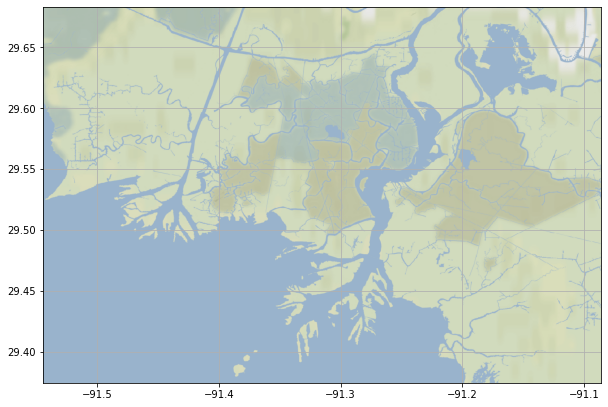

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

plot.show(stamen_arr, ax=ax, transform=transform)
ax.grid('on', zorder=2)

We are going to subset the rasters around a small area of Wax Lake.

In [22]:
sy, sx =  np.s_[:675], np.s_[100:775],
profile_c = get_cropped_profile(profile_4326, sx, sy)
transform_c = profile_c['transform']
x_min, y_min, x_max, y_max = array_bounds(profile_c['height'], 
                                          profile_c['width'], 
                                          profile_c['transform'])

We also have to translate all the networks to lat/lon again for visualization.

In [23]:
# Get All Nodes and Edges
edges_df_4326 = gpd.read_file(products_for_map_dir/'orinoco_edges.geojson').to_crs({'init':'epsg:4326'})
nodes_df_4326 = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson').to_crs({'init':'epsg:4326'})

# Get A GeoDataFrame to Draw the Source
nodes_df_source_4326 = nodes_df_source.to_crs({'init':'epsg:4326'})

# Get The Subnetwork using A Single Source
edges_df_sub_4326 = edges_df_sub.to_crs({'init':'epsg:4326'})
nodes_df_sub_4326 = nodes_df_sub.to_crs({'init':'epsg:4326'})

/Users/cmarshak/anaconda3/envs/orinoco_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/cmarshak/anaconda3/envs/orinoco_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/cmarshak/anaconda3/envs/orinoco_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the pre

We have quite the legend so we will have a separate cell to format the whole thing.

In [24]:
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'Source',
                          markerfacecolor='blue',
                          markeredgecolor='black',
                          alpha=1,
                          markersize=10)]

legend_elements += [Line2D([0], 
                           [0], 
                           marker='o',
                           color='w',
                           label=f'Outlet',
                           markerfacecolor='green',
                           markeredgecolor='black',
                           alpha=1,
                           markersize=10)]

legend_elements += [Line2D([0], 
                           [0], 
                           marker='>',
                           color='black',
                           markerfacecolor='blue',
                           markeredgecolor='blue',
                           label='Stream flow',
                           linewidth=1,
                           markersize=15)]
legend_elements += [Line2D([0], 
                           [0], 
                           marker=None,
                           color='black',
                           label='Subgraph',
                           linewidth=2,
                           markersize=10)]

legend_elements += [Line2D([0], 
                           [0], 
                           marker=None,
                           color='blue',
                           label='Full network',
                           linewidth=2,
                           markersize=10)]

We are going to overlay the network and have to reproject node positions and we quickly do so using geopandas as before.

In [26]:
# Slower, but equivalent
# from pyproj import Proj, transform
# df_nodes_original = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson')
# inProj = Proj(init=df_nodes_original.crs)
# outProj = Proj(init='epsg:4326')
# pos_r = {node: transform(inProj,outProj,*node) for node in H.nodes()}

# Open the original node file to get CRS
original_crs = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson').crs
# Obtain the node dataframe from H; need to make sure the nodes are precisely the same due to precision in lookup!
df_nodes_original = export_nodes_to_geodataframe(chanG_sub, crs=original_crs)
df_nodes_original['geometry_coords'] =df_nodes_original['geometry'].map(lambda point: point.coords[0])
df_nodes_original['geometry_coords_r'] =df_nodes_original['geometry'].to_crs({'init': 'epsg:4326'}).map(lambda point: point.coords[0])
pos_r = df_nodes_original.set_index('geometry_coords').to_dict()['geometry_coords_r']

/Users/cmarshak/anaconda3/envs/orinoco_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


We have to make arrows look pretty and take this rather circutious route we took in the previous notebook.

In [27]:
from orinoco import dfs_line_search, direct_line

#H = chanG_sub.copy()

# Determine interface nodes
interface_nodes = [node for node, data in chanG.nodes(data=True) if data['interface_adj']]
node_data = dict(chanG.nodes(data=True))

# Partition edges
def dfs_line_search_with_interface(G, source):
    def interface_criterion(node):
        return node_data[node]['interface_adj']
    return dfs_line_search(G, source, break_func=interface_criterion)

random_source = interface_nodes[0]
lines = list(dfs_line_search_with_interface(chanG_sub.to_undirected(), random_source))

# Ensure the lines are oriented
direct_line_partial = lambda line: direct_line(line, node_data)
lines = list(map(direct_line_partial, lines))

# Find edges that are part of group with size bigger than 2 and find 1/3rd point
edges_with_arrows_0 = [line[len(line)//3] for line in lines 
                     if len(line) > 2]
# Make sure we also label the edge groups next to interface
edges_with_arrows_1 = [line[len(line)//3] for line in lines 
                     if (node_data[line[-1][0]]['interface_adj']) | (node_data[line[-1][1]]['interface_adj'])]
edges_with_arrows = edges_with_arrows_0 + edges_with_arrows_1
len(edges_with_arrows)

18

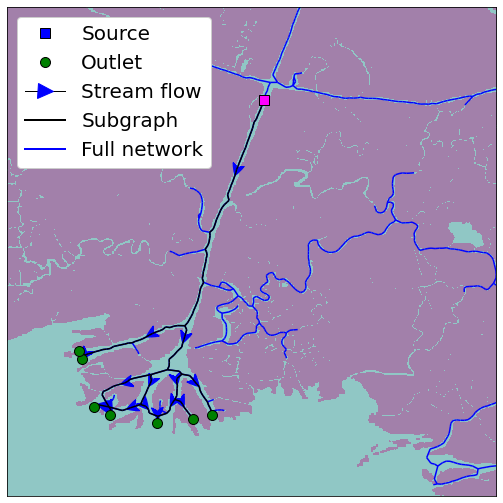

In [29]:
fig, ax = plt.subplots(figsize=(13, 9))
plot.show(water_mask[sy, sx], 
          ax=ax, 
          transform=transform_c, 
          zorder=0,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=.5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))


#############
# Centerlines
#############

# Whole Network
edges_df_4326.plot(ax=ax, edgecolor='blue', alpha=1)

# Subnetwork
edges_df_sub_4326.plot(ax=ax, edgecolor='black', alpha=1)


# The sources and sinks
nodes_df_sub_4326[nodes_df_sub_4326.interface_adj].plot(color='green', ax=ax, markersize=100, edgecolor='black', zorder=3)
nodes_df_source_4326.plot(color='blue', 
                          ax=ax, 
                          markersize=100, 
                          facecolor='magenta', 
                          edgecolor='black', 
                          marker='s', 
                          zorder=4)

####################
# Edges with Arrows
###################

ins, outs = zip(*edges_with_arrows)
H2 = chanG_sub.subgraph(list(set(ins + outs)))
nx.draw_networkx_edges(H2, 
                        pos=pos_r,
                        width=1.2,
                        edge_list=edges_with_arrows,
                        node_size=1,
                        arrows=True,
                        arrowstyle="fancy",
                        arrowsize=28,
                        ax=ax,
                        edge_color='blue',
                        zorder=1,
                        alpha=1,
                       )


########
# Legend
########

ax.legend(handles=legend_elements, loc='upper left', fontsize=20,  framealpha=1)
plt.savefig(plot_entropy/'entropy_fig.png')